In [2]:
import json
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..").resolve()
MASTER_DIR = ROOT / "data" / "master" / "master_lib.mat"
CASE_DIR =   ROOT / "data" / "cases"

def _resolve(f, x):
    while isinstance(x, h5py.Reference):
        x = f[x][()]
    if isinstance(x, np.ndarray) and x.size == 1:
        return _resolve(f, x.item())
    return x


def _matlab_str(f, x) -> str:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.dtype == np.uint16:
        return "".join(chr(c) for c in arr.flatten() if c != 0)
    if arr.shape == ():
        return str(arr.item())
    return str(arr)


def _matlab_int(f, x) -> int:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.shape == ():
        return int(arr.item())
    return int(arr.flatten()[0])


def deer_contour_from_mat(mat_path, *, category="deer", img_id=300):
    with h5py.File(mat_path, "r") as f:
        rec = f["records"]
        ds_cat = rec["category"]
        ds_id = rec["img_id"]
        ds_contour = rec["contour"]

        idx = None
        for i in range(ds_id.size):
            if _matlab_str(f, ds_cat[i]) == category and _matlab_int(f, ds_id[i]) == int(img_id):
                idx = i
                break
        if idx is None:
            raise ValueError(f"No record found for category='{category}', img_id={img_id}")

        contour = np.array(_resolve(f, ds_contour[idx]))

    if contour.ndim != 2:
        raise ValueError(f"Contour is not 2D, got {contour.shape}")
    if contour.shape[0] == 2 and contour.shape[1] != 2:
        contour = contour.T
    if contour.shape[1] != 2:
        raise ValueError(f"Expected Nx2 contour, got {contour.shape}")

    return contour.astype(float)


def add_oval_occluder_normcoords_plot_and_save_jsonl(
    mat_path: str,
    *,
    category: str = "deer",
    img_id: int = 300,

    # OVAL parameters you asked for
    occ_rx: float = 0.11,         # radius in x (half-width) in normalized space
    occ_ry: float = 0.08,         # radius in y (half-height) in normalized space

    # placement control
    occ_mode: str = "random",     # "center", "random", or "manual"
    occ_cx: float | None = None,  # manual center x
    occ_cy: float | None = None,  # manual center y

    # plotting and saving
    alpha: float = 0.6,
    jsonl_path: str = "deer_300_occ.jsonl",
    seed: int = 7,
    show: bool = True,

    # oval smoothness
    n_ellipse_pts: int = 80,
):
    rng = np.random.default_rng(seed)

    c = deer_contour_from_mat(mat_path, category=category, img_id=img_id)
    c_plot = np.vstack([c, c[0]]) if not np.allclose(c[0], c[-1]) else c

    min_xy = c.min(axis=0)
    max_xy = c.max(axis=0)

    # choose center
    if occ_mode == "center":
        cx = 0.5 * (min_xy[0] + max_xy[0])
        cy = 0.5 * (min_xy[1] + max_xy[1])
    elif occ_mode == "random":
        p = c[rng.integers(0, c.shape[0])]
        cx = float(p[0])
        cy = float(p[1])
    elif occ_mode == "manual":
        if occ_cx is None or occ_cy is None:
            raise ValueError("For occ_mode='manual', you must pass occ_cx and occ_cy.")
        cx = float(occ_cx)
        cy = float(occ_cy)
    else:
        raise ValueError("occ_mode must be 'center', 'random', or 'manual'")

    # clamp center so the oval stays within contour bounding box
    cx = float(np.clip(cx, min_xy[0] + occ_rx, max_xy[0] - occ_rx))
    cy = float(np.clip(cy, min_xy[1] + occ_ry, max_xy[1] - occ_ry))

    # build oval polygon points
    t = np.linspace(0.0, 2.0 * np.pi, int(n_ellipse_pts), endpoint=False)
    oval = np.column_stack([cx + occ_rx * np.cos(t), cy + occ_ry * np.sin(t)]).astype(float)

    fig = ax = None
    if show:
        fig, ax = plt.subplots(figsize=(5, 5))

        ax.fill(c_plot[:, 0], c_plot[:, 1],
                color="black", linewidth=0, zorder=1)

        ax.fill(oval[:, 0], oval[:, 1],
                color="#838383", linewidth=0, alpha=1, zorder=2)

        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.axis("off")
        ax.set_facecolor("white")

        pad = 0.02
        ax.set_xlim(min_xy[0] - pad, max_xy[0] + pad)
        ax.set_ylim(min_xy[1] - pad, max_xy[1] + pad)

        plt.show()

    # IMPORTANT: keep the SAME JSONL keys as the rectangle version
    row = {
        "ts_utc": time.time(),
        "source_mat": str(mat_path),
        "category": category,
        "img_id": int(img_id),
        "coord_system": "normalized_contour_space",
        "shape_contour_xy": c.tolist(),

        # same key name, but contains the oval polygon (Nx2)
        "occluder_rect_xy": oval.tolist(),

        # same key name/structure. w,h correspond to the oval's bounding box
        "occluder_rect_wh": {"w": float(2.0 * occ_rx), "h": float(2.0 * occ_ry)},

        "occluder_mode": occ_mode,
        "seed": int(seed),
        "plotting": {"invert_yaxis": True, "alpha": float(alpha)},
        "shape_bounds": {"min": min_xy.tolist(), "max": max_xy.tolist()},
    }

    with open(jsonl_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

    return row, (fig, ax)


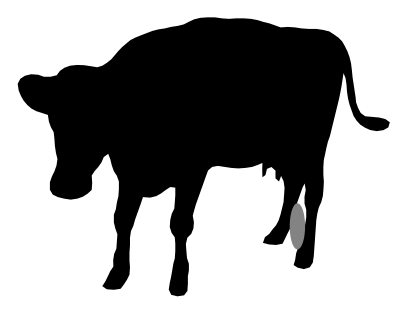

In [24]:
category="cow"
img_id = 8
JSON_DIR = CASE_DIR / f"{category}_{img_id}" / "generated"

for d in [JSON_DIR]:
    d.mkdir(parents=True, exist_ok=True)

row, _ = add_oval_occluder_normcoords_plot_and_save_jsonl(
     MASTER_DIR,
     category=category,
     img_id=img_id,
     occ_rx=0.02,
     occ_ry=0.06,
     occ_mode="manual",
     occ_cx=0.745,
     occ_cy=0.45,
     #jsonl_path= JSON_DIR / f"{category}_{img_id}.jsonl",
     jsonl_path= ROOT / "test.jsonl",
     seed=8,
     show=True
 )

# Feldman-Singh approach

In [3]:
# ============================================================
# Notebook: Information-guided occluder placement (Feldman & Singh-inspired)
# ============================================================

# ------------------------------------------------------------
# Cell 1. Imports + paths
# ------------------------------------------------------------
import json
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..").resolve()
MASTER_DIR = ROOT / "data" / "master" / "master_lib.mat"
CASE_DIR = ROOT / "data" / "cases"


In [4]:
# ------------------------------------------------------------
# Cell 2. MATLAB v7.3 helpers (unchanged)
# ------------------------------------------------------------
def _resolve(f, x):
    while isinstance(x, h5py.Reference):
        x = f[x][()]
    if isinstance(x, np.ndarray) and x.size == 1:
        return _resolve(f, x.item())
    return x


def _matlab_str(f, x) -> str:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.dtype == np.uint16:
        return "".join(chr(c) for c in arr.flatten() if c != 0)
    if arr.shape == ():
        return str(arr.item())
    return str(arr)


def _matlab_int(f, x) -> int:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.shape == ():
        return int(arr.item())
    return int(arr.flatten()[0])


def contour_from_mat(mat_path, *, category, img_id):
    with h5py.File(mat_path, "r") as f:
        rec = f["records"]
        ds_cat = rec["category"]
        ds_id = rec["img_id"]
        ds_contour = rec["contour"]

        idx = None
        for i in range(ds_id.size):
            if _matlab_str(f, ds_cat[i]) == category and _matlab_int(f, ds_id[i]) == int(img_id):
                idx = i
                break
        if idx is None:
            raise ValueError(f"No record found for category='{category}', img_id={img_id}")

        contour = np.array(_resolve(f, ds_contour[idx]))

    if contour.ndim != 2:
        raise ValueError(f"Contour is not 2D, got {contour.shape}")
    if contour.shape[0] == 2 and contour.shape[1] != 2:
        contour = contour.T
    if contour.shape[1] != 2:
        raise ValueError(f"Expected Nx2 contour, got {contour.shape}")

    return contour.astype(np.float64)


In [5]:
# ------------------------------------------------------------
# Cell 3. Geometry utilities: arclength, turning angles
# ------------------------------------------------------------
def close_contour(c: np.ndarray) -> np.ndarray:
    c = np.asarray(c, dtype=np.float64)
    if c.shape[0] < 3:
        raise ValueError("Contour too short.")
    if np.allclose(c[0], c[-1]):
        return c
    return np.vstack([c, c[0]])

def segment_lengths(c_closed: np.ndarray) -> np.ndarray:
    d = np.diff(c_closed, axis=0)
    return np.sqrt((d * d).sum(axis=1))

def turning_angles(c: np.ndarray) -> np.ndarray:
    """
    Signed turning angle at each vertex i, using neighbors (i-1, i, i+1).
    Returns angles for i=0..N-1 of the original open contour points.
    Assumes the contour is closed conceptually.
    """
    c = np.asarray(c, dtype=np.float64)
    N = c.shape[0]
    if N < 3:
        raise ValueError("Need at least 3 points for turning angles.")

    # indices with wraparound
    im1 = np.roll(np.arange(N), 1)
    ip1 = np.roll(np.arange(N), -1)

    v1 = c - c[im1]
    v2 = c[ip1] - c

    # normalize to avoid scale issues
    n1 = np.linalg.norm(v1, axis=1) + 1e-12
    n2 = np.linalg.norm(v2, axis=1) + 1e-12
    a = v1 / n1[:, None]
    b = v2 / n2[:, None]

    # signed angle between a and b via atan2(cross, dot)
    cross = a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]
    dot   = a[:, 0] * b[:, 0] + a[:, 1] * b[:, 1]
    ang = np.arctan2(cross, dot)  # in (-pi, pi]

    return ang


In [6]:
# ------------------------------------------------------------
# Cell 4. Feldman & Singh-inspired surprisal on turning angles
# ------------------------------------------------------------
def von_mises_kde_pdf(samples: np.ndarray, queries: np.ndarray, *, kappa: float) -> np.ndarray:
    """
    Circular KDE on angles using a von Mises kernel with concentration kappa.
    p(q) = mean_j [ exp(kappa*cos(q - s_j)) ] / (2*pi*I0(kappa))
    Uses np.i0 for the modified Bessel function I0.
    """
    samples = np.asarray(samples, dtype=np.float64).reshape(-1)
    queries = np.asarray(queries, dtype=np.float64).reshape(-1)

    # broadcast differences: (Q, S)
    diff = queries[:, None] - samples[None, :]
    num = np.exp(kappa * np.cos(diff)).mean(axis=1)

    denom = 2.0 * np.pi * np.i0(kappa)
    return num / max(1e-12, denom)

def contour_information_surprisal(c: np.ndarray, *, kappa: float = 25.0, eps: float = 1e-12):
    """
    Compute:
      alpha_i = turning angle at vertex i
      p(alpha_i) from KDE over all alphas on this contour
      u_i = -log p(alpha_i)
    Returns alpha, p, u.
    """
    alpha = turning_angles(c)
    p = von_mises_kde_pdf(alpha, alpha, kappa=float(kappa))
    u = -np.log(np.clip(p, eps, None))
    return alpha, p, u


In [7]:
def _as_open_unique_contour(c: np.ndarray) -> np.ndarray:
    """
    Ensure contour is (N,2) with no duplicate closing point.
    If the first and last points are the same, drop the last.
    """
    c = np.asarray(c, dtype=np.float64)
    if c.shape[0] < 3:
        raise ValueError("Contour too short.")
    if np.allclose(c[0], c[-1]):
        c = c[:-1]
    if c.shape[0] < 3:
        raise ValueError("Contour too short after removing duplicate endpoint.")
    return c

def select_max_info_window(c: np.ndarray, u: np.ndarray, *, frac: float = 0.25):
    """
    Choose a contiguous arc-length window covering frac of the perimeter
    that maximizes integrated surprisal.
    """
    c = _as_open_unique_contour(c)
    u = np.asarray(u, dtype=np.float64).reshape(-1)

    N = c.shape[0]
    if u.shape[0] != N:
        raise ValueError(f"u must have same length as contour points. got u={u.shape[0]}, c={N}")

    # build a closed version for edge-length computation (N edges)
    c_closed = np.vstack([c, c[0]])
    d = np.diff(c_closed, axis=0)
    ds_edges = np.sqrt((d * d).sum(axis=1))  # shape (N,)
    perim = float(ds_edges.sum())
    L = float(np.clip(frac, 1e-6, 1.0)) * perim

    # weight per edge: assign vertex surprisal to outgoing edge
    w_edges = u * ds_edges  # shape (N,)

    # duplicate for wraparound
    ds2 = np.concatenate([ds_edges, ds_edges])
    w2  = np.concatenate([w_edges,  w_edges])

    best_sum = -np.inf
    best_i = 0
    best_j = 0

    s = 0.0
    wsum = 0.0
    j = 0
    for i in range(N):
        if j < i:
            j = i
            s = 0.0
            wsum = 0.0

        while j < i + N and s < L:
            s += ds2[j]
            wsum += w2[j]
            j += 1

        if s >= L and wsum > best_sum:
            best_sum = float(wsum)
            best_i = int(i)
            best_j = int(j)

        s -= ds2[i]
        wsum -= w2[i]

    covered_len = float(ds2[best_i:best_j].sum())
    covered_frac = covered_len / perim if perim > 0 else np.nan

    return {
        "start_i": best_i,
        "end_j": best_j,
        "perimeter": perim,
        "target_len": L,
        "covered_len": covered_len,
        "covered_frac": covered_frac,
        "best_integrated_surprisal": best_sum,
    }


In [8]:
# ------------------------------------------------------------
# Cell 6. Visualization: information density along contour (before selection)
# ------------------------------------------------------------
def plot_info_on_contour(c: np.ndarray, u: np.ndarray, *, title: str = "Contour information (surprisal)"):
    """
    Scatter plot of contour points colored by surprisal u.
    """
    c = np.asarray(c, dtype=np.float64)
    u = np.asarray(u, dtype=np.float64).reshape(-1)

    c_plot = close_contour(c)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(c_plot[:, 0], c_plot[:, 1], linewidth=1.0)

    sc = ax.scatter(c[:, 0], c[:, 1], c=u, s=10)
    cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("u = -log p(alpha)")

    ax.set_title(title)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.axis("off")
    plt.show()

    return fig, ax


In [9]:
# ------------------------------------------------------------
# Cell. Rotated ellipse (aligned to tangent)
# ------------------------------------------------------------
def build_rotated_oval(cx, cy, rx, ry, theta, *, n_pts: int = 80) -> np.ndarray:
    t = np.linspace(0.0, 2.0 * np.pi, int(n_pts), endpoint=False)
    x = rx * np.cos(t)
    y = ry * np.sin(t)

    ct = np.cos(theta)
    st = np.sin(theta)
    xr = ct * x - st * y
    yr = st * x + ct * y

    return np.column_stack([cx + xr, cy + yr]).astype(np.float64)


In [10]:
def build_rotated_rect(cx, cy, w, h, theta, *, as_float64: bool = True) -> np.ndarray:
    """
    Rotated rectangle polygon (4x2), centered at (cx,cy).
    w,h are full width/height in your normalized contour space.
    theta in radians, same convention as your ellipse.
    Returns vertices in order.
    """
    hw = 0.5 * float(w)
    hh = 0.5 * float(h)

    # axis-aligned corners (counter-clockwise)
    corners = np.array([
        [-hw, -hh],
        [ hw, -hh],
        [ hw,  hh],
        [-hw,  hh],
    ], dtype=np.float64)

    ct = np.cos(theta)
    st = np.sin(theta)
    R = np.array([[ct, -st],
                  [st,  ct]], dtype=np.float64)

    rot = corners @ R.T
    poly = rot + np.array([float(cx), float(cy)], dtype=np.float64)

    return poly.astype(np.float64) if as_float64 else poly


In [11]:
# ------------------------------------------------------------
# Cell. Helpers: sample random point on window + tangent
# ------------------------------------------------------------
def _as_open_unique_contour(c: np.ndarray) -> np.ndarray:
    c = np.asarray(c, dtype=np.float64)
    if np.allclose(c[0], c[-1]):
        c = c[:-1]
    return c

def _edge_lengths_open(c_open: np.ndarray) -> np.ndarray:
    # N edges for N vertices (i -> i+1, last -> first)
    c_open = _as_open_unique_contour(c_open)
    c_closed = np.vstack([c_open, c_open[0]])
    d = np.diff(c_closed, axis=0)
    return np.sqrt((d * d).sum(axis=1))

def sample_point_on_window(c_open: np.ndarray, start_i: int, end_j: int, rng: np.random.Generator):
    """
    Uniform-by-arc-length sample within edges [start_i, end_j) (in duplicated indexing).
    Returns (cx, cy, edge_idx, t_along_edge) where edge_idx is in 0..N-1.
    """
    c_open = _as_open_unique_contour(c_open)
    N = c_open.shape[0]
    ds = _edge_lengths_open(c_open)
    ds2 = np.concatenate([ds, ds])

    edges = np.arange(start_i, end_j)
    lens = ds2[edges]
    total = float(lens.sum())
    if total <= 0:
        # fallback: just return the start vertex
        p = c_open[start_i % N]
        return float(p[0]), float(p[1]), int(start_i % N), 0.0, 0.0, total

    r = float(rng.random() * total)
    acc = 0.0
    for e, L in zip(edges, lens):
        L = float(L)
        if acc + L >= r:
            t = (r - acc) / max(1e-12, L)
            v = int(e % N)
            p0 = c_open[v]
            p1 = c_open[(v + 1) % N]
            p = (1.0 - t) * p0 + t * p1
            return float(p[0]), float(p[1]), v, float(t), float(L), total
        acc += L

    # numerical fallback
    v = int(edges[-1] % N)
    p = c_open[v]
    return float(p[0]), float(p[1]), v, 0.0, float(ds[v]), total

def tangent_angle_at_edge(c_open: np.ndarray, edge_v: int):
    """
    Tangent direction along edge edge_v: v -> v+1.
    Returns angle theta in radians.
    """
    c_open = _as_open_unique_contour(c_open)
    N = c_open.shape[0]
    p0 = c_open[edge_v]
    p1 = c_open[(edge_v + 1) % N]
    v = p1 - p0
    return float(np.arctan2(v[1], v[0]))


# With Fit

In [12]:
# ------------------------------------------------------------
# Cell. Info-guided occluder placement (random within max-info segment),
#       size = occ_size_frac_of_segment of segment length,
#       then ORIENT + OUTWARD-SHIFT to (a) maximize occluded contour in-window
#       and (b) minimize intrusion into the silhouette.
#       Saves JSONL with legacy keys.
# ------------------------------------------------------------
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.path import Path as MplPath

# ---------- helpers (contour convention + geometry) ----------
def _as_open_unique_contour(c: np.ndarray) -> np.ndarray:
    c = np.asarray(c, dtype=np.float64)
    if c.shape[0] < 3:
        raise ValueError("Contour too short.")
    if np.allclose(c[0], c[-1]):
        c = c[:-1]
    if c.shape[0] < 3:
        raise ValueError("Contour too short after removing duplicate endpoint.")
    return c

def _edge_lengths_open(c_open: np.ndarray) -> np.ndarray:
    c_open = _as_open_unique_contour(c_open)
    c_closed = np.vstack([c_open, c_open[0]])
    d = np.diff(c_closed, axis=0)
    return np.sqrt((d * d).sum(axis=1))  # N edges for N vertices

def sample_point_on_window(c_open: np.ndarray, start_i: int, end_j: int, rng: np.random.Generator):
    """
    Uniform-by-arc-length sample within edges [start_i, end_j) (in duplicated indexing).
    Returns (cx, cy, edge_v, t_along_edge, seg_len).
      - edge_v in 0..N-1 refers to edge edge_v: v -> v+1
      - t_along_edge in [0,1]
      - seg_len is the arc-length of the selected segment
    """
    c_open = _as_open_unique_contour(c_open)
    N = c_open.shape[0]
    ds = _edge_lengths_open(c_open)
    ds2 = np.concatenate([ds, ds])

    edges = np.arange(int(start_i), int(end_j))
    if edges.size == 0:
        p = c_open[int(start_i) % N]
        return float(p[0]), float(p[1]), int(start_i) % N, 0.0, 0.0

    lens = ds2[edges]
    seg_len = float(lens.sum())
    if seg_len <= 0:
        p = c_open[int(start_i) % N]
        return float(p[0]), float(p[1]), int(start_i) % N, 0.0, seg_len

    r = float(rng.random() * seg_len)
    acc = 0.0
    for e, L in zip(edges, lens):
        L = float(L)
        if acc + L >= r:
            t = (r - acc) / max(1e-12, L)
            v = int(e % N)
            p0 = c_open[v]
            p1 = c_open[(v + 1) % N]
            p = (1.0 - t) * p0 + t * p1
            return float(p[0]), float(p[1]), v, float(t), seg_len
        acc += L

    # fallback
    v = int(edges[-1] % N)
    p = c_open[v]
    return float(p[0]), float(p[1]), v, 0.0, seg_len

def tangent_angle_at_edge(c_open: np.ndarray, edge_v: int) -> float:
    c_open = _as_open_unique_contour(c_open)
    N = c_open.shape[0]
    p0 = c_open[int(edge_v) % N]
    p1 = c_open[(int(edge_v) + 1) % N]
    v = p1 - p0
    return float(np.arctan2(v[1], v[0]))

def build_rotated_oval(cx, cy, rx, ry, theta, *, n_pts: int = 80) -> np.ndarray:
    t = np.linspace(0.0, 2.0 * np.pi, int(n_pts), endpoint=False)
    x = rx * np.cos(t)
    y = ry * np.sin(t)
    ct = np.cos(theta)
    st = np.sin(theta)
    xr = ct * x - st * y
    yr = st * x + ct * y
    return np.column_stack([cx + xr, cy + yr]).astype(np.float64)

def close_contour_plot(c_open: np.ndarray) -> np.ndarray:
    c_open = _as_open_unique_contour(c_open)
    return np.vstack([c_open, c_open[0]])

# ---------- optimization helpers ----------
def polygon_signed_area(c_open: np.ndarray) -> float:
    c = _as_open_unique_contour(c_open)
    x = c[:, 0]
    y = c[:, 1]
    return 0.5 * float(np.sum(x * np.roll(y, -1) - np.roll(x, -1) * y))

def _unit(v: np.ndarray) -> np.ndarray:
    n = float(np.linalg.norm(v))
    return v / max(1e-12, n)

def outward_normal_from_tangent(c_open: np.ndarray, edge_v: int) -> np.ndarray:
    """
    Outward normal at edge edge_v (v->v+1), based on polygon orientation.
    CCW: interior left of edge -> outward is right normal.
    CW:  interior right of edge -> outward is left normal.
    """
    c = _as_open_unique_contour(c_open)
    N = c.shape[0]
    p0 = c[edge_v]
    p1 = c[(edge_v + 1) % N]
    t = _unit(p1 - p0)

    n_left  = np.array([-t[1], t[0]], dtype=np.float64)
    n_right = np.array([ t[1],-t[0]], dtype=np.float64)

    ccw = polygon_signed_area(c) > 0
    return n_right if ccw else n_left

def points_in_ellipse(pts: np.ndarray, cx: float, cy: float, rx: float, ry: float, theta: float) -> np.ndarray:
    """
    Test points (Nx2) inside rotated ellipse centered at (cx,cy).
    """
    pts = np.asarray(pts, dtype=np.float64)
    ct = np.cos(theta); st = np.sin(theta)
    d = pts - np.array([cx, cy], dtype=np.float64)

    # rotate into ellipse frame: R(-theta)
    x =  ct * d[:, 0] + st * d[:, 1]
    y = -st * d[:, 0] + ct * d[:, 1]
    return (x / max(1e-12, rx))**2 + (y / max(1e-12, ry))**2 <= 1.0

def ellipse_intrusion_fraction_mc(c_open: np.ndarray, cx: float, cy: float, rx: float, ry: float, theta: float,
                                  *, n_samples: int = 800, rng_seed: int = 0) -> float:
    """
    Approx fraction of ellipse area inside polygon (silhouette) via MC sampling.
    """
    c = _as_open_unique_contour(c_open)
    poly = MplPath(c, closed=True)

    rng = np.random.default_rng(int(rng_seed))
    ang = rng.random(n_samples) * 2.0 * np.pi
    rad = np.sqrt(rng.random(n_samples))
    xs = rx * rad * np.cos(ang)
    ys = ry * rad * np.sin(ang)

    ct = np.cos(theta); st = np.sin(theta)
    xr = ct * xs - st * ys
    yr = st * xs + ct * ys
    samp = np.column_stack([cx + xr, cy + yr])

    inside = poly.contains_points(samp)
    return float(np.mean(inside))

def contour_occlusion_count(c_open: np.ndarray, window_start_i: int, window_end_j: int,
                            cx: float, cy: float, rx: float, ry: float, theta: float) -> float:
    """
    Count how many contour vertices (restricted to window) are inside ellipse.
    """
    c = _as_open_unique_contour(c_open)
    N = c.shape[0]
    idxs = (np.arange(int(window_start_i), int(window_end_j)) % N).astype(int)
    pts = c[idxs]
    return float(np.sum(points_in_ellipse(pts, cx, cy, rx, ry, theta)))

def choose_orientation_and_shift(
    c_open: np.ndarray,
    *,
    window_start_i: int,
    window_end_j: int,
    base_cx: float,
    base_cy: float,
    edge_v: int,
    rx: float,
    ry: float,
    theta_tangent: float,
    # search
    max_rot_deg: float = 25.0,
    rot_step_deg: float = 2.5,
    max_shift: float | None = None,    # default: 0.9*ry
    shift_step: float | None = None,   # default: 0.1*ry
    # objective
    w_intrude: float = 30.0,
    intrusion_mc_samples: int = 800,
):
    """
    Grid search:
      theta in [theta_tangent ± max_rot_deg]
      center shifted outward along normal by d in [0, max_shift]
    Objective:
      occ_count - w_intrude * intrusion_fraction
    """
    c = _as_open_unique_contour(c_open)

    if max_shift is None:
        max_shift = 0.9 * float(ry)
    if shift_step is None:
        shift_step = 0.1 * float(ry)

    n_out = outward_normal_from_tangent(c, int(edge_v))
    rots = np.deg2rad(np.arange(-max_rot_deg, max_rot_deg + 1e-12, rot_step_deg))
    shifts = np.arange(0.0, float(max_shift) + 1e-12, float(shift_step))

    best = {"obj": -np.inf}
    for d in shifts:
        cx = float(base_cx + d * n_out[0])
        cy = float(base_cy + d * n_out[1])
        for dr in rots:
            th = float(theta_tangent + float(dr))

            occ = contour_occlusion_count(c, window_start_i, window_end_j, cx, cy, rx, ry, th)
            intr = ellipse_intrusion_fraction_mc(
                c, cx, cy, rx, ry, th,
                n_samples=int(intrusion_mc_samples),
                rng_seed=0
            )
            obj = float(occ) - float(w_intrude) * float(intr)

            if obj > best["obj"]:
                best = {
                    "obj": obj,
                    "cx": cx, "cy": cy, "theta": th,
                    "occ_count": float(occ),
                    "intrude_frac": float(intr),
                    "shift": float(d),
                    "rot_deg": float(np.rad2deg(dr)),
                }
    return best

# ---------- your existing functions assumed present ----------
# contour_from_mat(...)
# contour_information_surprisal(...)
# select_max_info_window(...)

def add_oval_occluder_info_guided_random_in_segment_aligned_optimized_plot_and_save_jsonl(
    mat_path: str,
    *,
    category: str,
    img_id: int,

    # base aspect ratio (ry/rx). These are NOT absolute sizes anymore.
    occ_rx: float = 0.02,
    occ_ry: float = 0.06,

    # selection control
    occ_frac: float = 0.25,
    kde_kappa: float = 25.0,
    occ_size_frac_of_segment: float = 0.10,

    # optimization knobs
    max_rot_deg: float = 25.0,
    rot_step_deg: float = 2.5,
    max_shift_frac_of_ry: float = 0.9,
    shift_step_frac_of_ry: float = 0.1,
    w_intrude: float = 30.0,
    intrusion_mc_samples: int = 800,

    # plotting & saving
    jsonl_path: str | Path = "case.jsonl",
    seed: int = 7,
    show: bool = True,
    n_ellipse_pts: int = 80,
):
    rng = np.random.default_rng(int(seed))

    # 1) load contour and enforce open/unique convention
    c_raw = contour_from_mat(mat_path, category=category, img_id=img_id)
    c = _as_open_unique_contour(c_raw)

    # 2) compute surprisal along contour
    alpha, p, u = contour_information_surprisal(c, kappa=float(kde_kappa))

    # 3) select max-info segment (window)
    win = select_max_info_window(c, u, frac=float(occ_frac))
    start_i, end_j = int(win["start_i"]), int(win["end_j"])

    # 4) sample random center within segment (uniform by arc-length)
    base_cx, base_cy, edge_v, t_edge, seg_len = sample_point_on_window(c, start_i, end_j, rng)

    # 5) occluder size from segment length
    major_len = float(occ_size_frac_of_segment) * float(seg_len)
    rx = 0.5 * major_len
    aspect = float(occ_ry) / max(1e-12, float(occ_rx))
    ry = rx * aspect

    # 6) tangent angle
    theta_tan = tangent_angle_at_edge(c, edge_v)

    # 7) optimize orientation + outward shift
    best = choose_orientation_and_shift(
        c,
        window_start_i=start_i,
        window_end_j=end_j,
        base_cx=base_cx,
        base_cy=base_cy,
        edge_v=edge_v,
        rx=rx,
        ry=ry,
        theta_tangent=theta_tan,
        max_rot_deg=float(max_rot_deg),
        rot_step_deg=float(rot_step_deg),
        max_shift=float(max_shift_frac_of_ry) * float(ry),
        shift_step=float(shift_step_frac_of_ry) * float(ry),
        w_intrude=float(w_intrude),
        intrusion_mc_samples=int(intrusion_mc_samples),
    )

    cx, cy, theta = float(best["cx"]), float(best["cy"]), float(best["theta"])
    oval = build_rotated_oval(cx, cy, rx, ry, theta, n_pts=int(n_ellipse_pts))

    # bounds
    min_xy = c.min(axis=0)
    max_xy = c.max(axis=0)

    # 8) plotting
    fig = ax = None
    if show:
        c_plot = close_contour_plot(c)

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.fill(c_plot[:, 0], c_plot[:, 1], color="black", linewidth=0, zorder=1)

        # highlight selected segment on the contour
        N = c.shape[0]
        idxs = (np.arange(start_i, end_j) % N).astype(int)
        pts = c[idxs]
        if pts.shape[0] >= 2:
            ax.plot(pts[:, 0], pts[:, 1], linewidth=3.0, zorder=3)

        # draw oval
        ax.fill(oval[:, 0], oval[:, 1], color="#838383", linewidth=0, alpha=1, zorder=4)

        # base vs optimized centers
        ax.scatter([base_cx], [base_cy], s=20, zorder=5)
        ax.scatter([cx], [cy], s=40, zorder=6)

        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.axis("off")
        ax.set_facecolor("white")

        pad = 0.02
        ax.set_xlim(min_xy[0] - pad, max_xy[0] + pad)
        ax.set_ylim(min_xy[1] + pad, max_xy[1] - pad)

        ax.set_title(
            f"Optimized: occ={best['occ_count']:.0f}, intr={best['intrude_frac']:.3f}, "
            f"shift={best['shift']:.4f}, rot={best['rot_deg']:.1f}°"
        )
        plt.show()

    # 9) JSONL row (keeps SAME keys used downstream)
    row = {
        "ts_utc": time.time(),
        "source_mat": str(mat_path),
        "category": category,
        "img_id": int(img_id),
        "coord_system": "normalized_contour_space",
        "shape_contour_xy": c.tolist(),

        # legacy keys
        "occluder_rect_xy": oval.tolist(),
        "occluder_rect_wh": {"w": float(2.0 * rx), "h": float(2.0 * ry)},

        "occluder_mode": "info_guided_random_in_segment_aligned_optimized",
        "seed": int(seed),

        "info_guided": {
            "paper": "Feldman & Singh (2004) surprisal on turning angles (contour-only KDE)",
            "occ_frac_segment": float(occ_frac),
            "kde_kappa": float(kde_kappa),
            "window_start_i": int(start_i),
            "window_end_j": int(end_j),
            "window_stats": win,

            "random_center_uniform_arclength": True,
            "segment_len": float(seg_len),
            "occ_size_frac_of_segment": float(occ_size_frac_of_segment),
            "major_len": float(major_len),
            "rx": float(rx),
            "ry": float(ry),
            "theta_tangent_rad": float(theta_tan),
            "sampled_edge_v": int(edge_v),
            "sampled_t_edge": float(t_edge),
            "base_center_xy": [float(base_cx), float(base_cy)],

            "optimized": {
                "center_xy": [float(cx), float(cy)],
                "theta_rad": float(theta),
                "rot_deg_from_tangent": float(best["rot_deg"]),
                "outward_shift": float(best["shift"]),
                "occ_count_vertices_in_window": float(best["occ_count"]),
                "intrude_area_frac_mc": float(best["intrude_frac"]),
                "w_intrude": float(w_intrude),
                "intrusion_mc_samples": int(intrusion_mc_samples),
                "max_rot_deg": float(max_rot_deg),
                "rot_step_deg": float(rot_step_deg),
                "max_shift_frac_of_ry": float(max_shift_frac_of_ry),
                "shift_step_frac_of_ry": float(shift_step_frac_of_ry),
            },
        },

        "plotting": {"invert_yaxis": True},
        "shape_bounds": {"min": min_xy.tolist(), "max": max_xy.tolist()},
    }

    jsonl_path = Path(jsonl_path)
    jsonl_path.parent.mkdir(parents=True, exist_ok=True)
    with open(jsonl_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

    return row, (fig, ax), (alpha, p, u), win, best


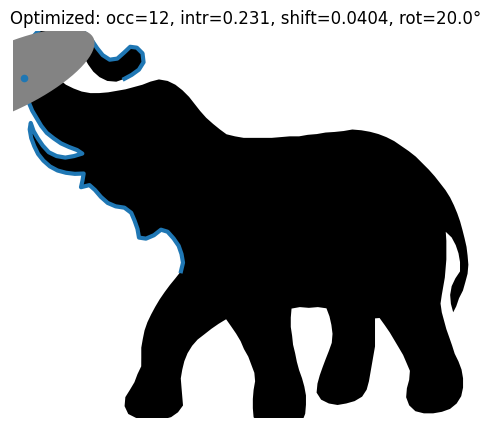

{'obj': 2.75, 'cx': 0.027545010119238406, 'cy': 0.7737649644093743, 'theta': -1.1378461842768177, 'occ_count': 12.0, 'intrude_frac': 0.23125, 'shift': 0.0403855307183537, 'rot_deg': 20.0}


In [91]:
category = "elephant"
img_id = 7

JSON_DIR = CASE_DIR / f"{category}_{img_id}" / "generated"
JSON_DIR.mkdir(parents=True, exist_ok=True)

row, _, (alpha, p, u), win, best = add_oval_occluder_info_guided_random_in_segment_aligned_optimized_plot_and_save_jsonl(
    MASTER_DIR,
    category=category,
    img_id=img_id,
    occ_frac=0.25,
    kde_kappa=25.0,
    occ_size_frac_of_segment=0.1,
    w_intrude=40.0,
    max_rot_deg=20.0,
    rot_step_deg=1.0,
    max_shift_frac_of_ry=0.3,
    shift_step_frac_of_ry=0.05,
    jsonl_path=ROOT / "test.jsonl",
    #jsonl_path= JSON_DIR / f"{category}_{img_id}.jsonl",
    seed=8,
    show=True,
)
print(best)


In [21]:
def add_rect_occluder_normcoords_plot_and_save_jsonl(
    mat_path: str,
    *,
    category: str,
    img_id: int,

    # RECT parameters in normalized contour space
    occ_w: float = 0.10,
    occ_h: float = 0.06,
    occ_theta_deg: float = 0.0,

    # placement control (manual)
    occ_mode: str = "manual",
    occ_cx: float | None = None,
    occ_cy: float | None = None,

    # Feldman–Singh overlay
    show_info_segment: bool = True,
    occ_frac: float = 0.25,
    kde_kappa: float = 25.0,

    # plotting and saving
    jsonl_path: str | Path = "case.jsonl",
    seed: int = 7,
    show: bool = True,
):
    rng = np.random.default_rng(int(seed))

    # --------------------------------------------------
    # Load contour
    # --------------------------------------------------
    c_raw = contour_from_mat(mat_path, category=category, img_id=img_id)
    c = _as_open_unique_contour(c_raw)
    c_plot = close_contour_plot(c)

    min_xy = c.min(axis=0)
    max_xy = c.max(axis=0)

    # --------------------------------------------------
    # Feldman–Singh surprisal + max-info window
    # --------------------------------------------------
    win = None
    start_i = end_j = None

    if show_info_segment:
        alpha, p, u = contour_information_surprisal(c, kappa=float(kde_kappa))
        win = select_max_info_window(c, u, frac=float(occ_frac))
        start_i = int(win["start_i"])
        end_j = int(win["end_j"])

    # --------------------------------------------------
    # Manual placement checks
    # --------------------------------------------------
    if occ_mode != "manual":
        raise ValueError("This helper is for manual rectangle placement only (occ_mode='manual').")

    if occ_cx is None or occ_cy is None:
        raise ValueError("For manual rectangle, pass occ_cx and occ_cy.")

    cx = float(occ_cx)
    cy = float(occ_cy)

    # Clamp center to bounding box (soft clamp)
    pad_x = 0.5 * float(occ_w)
    pad_y = 0.5 * float(occ_h)
    cx = float(np.clip(cx, min_xy[0] + pad_x, max_xy[0] - pad_x))
    cy = float(np.clip(cy, min_xy[1] + pad_y, max_xy[1] - pad_y))

    theta = float(np.deg2rad(float(occ_theta_deg)))

    # --------------------------------------------------
    # Build rotated rectangle polygon
    # --------------------------------------------------
    rect = build_rotated_rect(cx, cy, occ_w, occ_h, theta)

    # --------------------------------------------------
    # Plot
    # --------------------------------------------------
    fig = ax = None
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))

        # silhouette
        ax.fill(
            c_plot[:, 0],
            c_plot[:, 1],
            color="black",
            linewidth=0,
            zorder=1,
        )

        # Feldman–Singh informative segment
        if show_info_segment and start_i is not None and end_j is not None:
            N = c.shape[0]
            idxs = (np.arange(start_i, end_j) % N).astype(int)
            pts = c[idxs]
            if pts.shape[0] >= 2:
                ax.plot(
                    pts[:, 0],
                    pts[:, 1],
                    linewidth=3.0,
                    zorder=3,
                )

        # rectangle occluder
        ax.fill(
            rect[:, 0],
            rect[:, 1],
            color="#838383",
            linewidth=0,
            alpha=1,
            zorder=4,
        )

        # center point
        ax.scatter([cx], [cy], s=40, zorder=5)

        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.axis("off")
        ax.set_facecolor("white")

        pad = 0.02
        ax.set_xlim(min_xy[0] - pad, max_xy[0] + pad)
        ax.set_ylim(min_xy[1] + pad, max_xy[1] - pad)

        title = f"Manual rectangle (rot={occ_theta_deg:.1f}°)"
        if show_info_segment:
            title += f" | Max-info {int(occ_frac*100)}%"
        ax.set_title(title)

        plt.show()

    # --------------------------------------------------
    # JSONL row (same legacy keys)
    # --------------------------------------------------
    row = {
        "ts_utc": time.time(),
        "source_mat": str(mat_path),
        "category": category,
        "img_id": int(img_id),
        "coord_system": "normalized_contour_space",
        "shape_contour_xy": c.tolist(),

        # legacy polygon key
        "occluder_rect_xy": rect.tolist(),
        "occluder_rect_wh": {
            "w": float(occ_w),
            "h": float(occ_h),
        },

        "occluder_mode": "manual_rect",
        "seed": int(seed),

        "plotting": {"invert_yaxis": True},
        "shape_bounds": {
            "min": min_xy.tolist(),
            "max": max_xy.tolist(),
        },

        "manual": {
            "shape": "rect",
            "center_xy": [float(cx), float(cy)],
            "theta_deg": float(occ_theta_deg),
        },

        "info_guided_overlay": None if not show_info_segment else {
            "paper": "Feldman & Singh (2004) surprisal on turning angles (contour-only KDE)",
            "occ_frac_segment": float(occ_frac),
            "kde_kappa": float(kde_kappa),
            "window_start_i": int(start_i),
            "window_end_j": int(end_j),
            "window_stats": win,
        },
    }

    jsonl_path = Path(jsonl_path)
    jsonl_path.parent.mkdir(parents=True, exist_ok=True)
    with open(jsonl_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

    return row, (fig, ax)


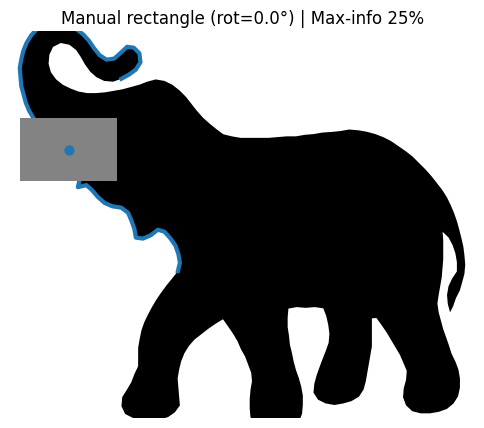

In [107]:
row, _ = add_rect_occluder_normcoords_plot_and_save_jsonl(
    MASTER_DIR,
    category=category,
    img_id=img_id,
    occ_w=0.2,
    occ_h=0.13,
    occ_theta_deg=0,
    occ_cx=0.12,
    occ_cy=0.63,
    #jsonl_path=ROOT / "test.jsonl",
    jsonl_path=JSON_DIR / "elephant_7_val_1.jsonl",
    seed=8,
    show=True,
    show_info_segment=True,
    occ_frac=0.25,
    kde_kappa=25.0,
)
